In [1]:
import sys
sys.path.append("..")

In [2]:
from dtacs.model_wrapper import ACModel, CDModel
import torch

assert torch.__version__ >= "1.13", f"Requires torch version >=1.13 current version {torch.__version__ }"

/home/gonzalo/miniconda3/envs/starcop/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [3]:
import rasterio
import os

phisat2_bands = ["B2","B3","B4","B5","B6","B7","B8"]

folder_examples = "examples"
# folder_examples = "gs://dtacs/cloudSEN12/high/ROI_0190/20200413T182919_20200413T183311_T12UVB"
# folder_examples = "gs://dtacs/cloudSEN12/high/ROI_0190/20190817T182929_20190817T183126_T12UVB"

# folder_examples = "gs://dtacs/cloudSEN12/high/ROI_0202/20190706T160839_20190706T161128_T17TNJ"

folder_examples = "gs://dtacs/cloudSEN12/high/ROI_0312/20191111T132241_20191111T132235_T23LLK"


with rasterio.open(os.path.join(folder_examples,"S2L1C.tif")) as rst:
    indexes_read = [rst.descriptions.index(b) + 1 for b in phisat2_bands]
    data = rst.read(indexes_read)
data.shape

(7, 509, 509)

## Load model

In [4]:
import torch

model_cd_torchscript = torch.jit.load('../models/cloud4bands.pt', map_location='cpu')
model_cloud_detection = CDModel(model=model_cd_torchscript)

model_atmospheric_correction = ACModel(input_bands=phisat2_bands,output_bands=phisat2_bands)
model_atmospheric_correction.load_weights("../models/model_ac_phisat2.pt")

## Run inference

In [5]:
data_cloud_detection = data[[-1,2,1,0],...]

cd_output = model_cloud_detection.predict(data_cloud_detection)
cd_output

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=uint8)

In [6]:
ac_output = model_atmospheric_correction.predict(data)
ac_output

array([[[ 417,  396,  388, ...,  526,  537,  506],
        [ 423,  416,  412, ...,  489,  522,  521],
        [ 447,  390,  397, ...,  496,  530,  552],
        ...,
        [ 451, 1153, 1614, ...,  394,  445,  427],
        [ 989, 1968, 2301, ...,  419,  437,  461],
        [1237, 2103, 2449, ...,  408,  436,  436]],

       [[ 710,  678,  668, ...,  825,  852,  833],
        [ 728,  713,  710, ...,  770,  833,  846],
        [ 762,  718,  700, ...,  772,  857,  875],
        ...,
        [1059, 1913, 2236, ...,  766,  794,  721],
        [1575, 2413, 2677, ...,  768,  775,  749],
        [1661, 2303, 2699, ...,  775,  795,  790]],

       [[ 646,  629,  532, ..., 1044, 1027,  948],
        [ 674,  651,  612, ...,  900, 1004, 1012],
        [ 722,  592,  594, ...,  859,  918,  970],
        ...,
        [1530, 2249, 2493, ...,  494,  452,  483],
        [1768, 2415, 2710, ...,  479,  458,  485],
        [1618, 2247, 2780, ...,  424,  459,  456]],

       ...,

       [[2503, 2541, 253

## Plot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Cloud shadow mask')

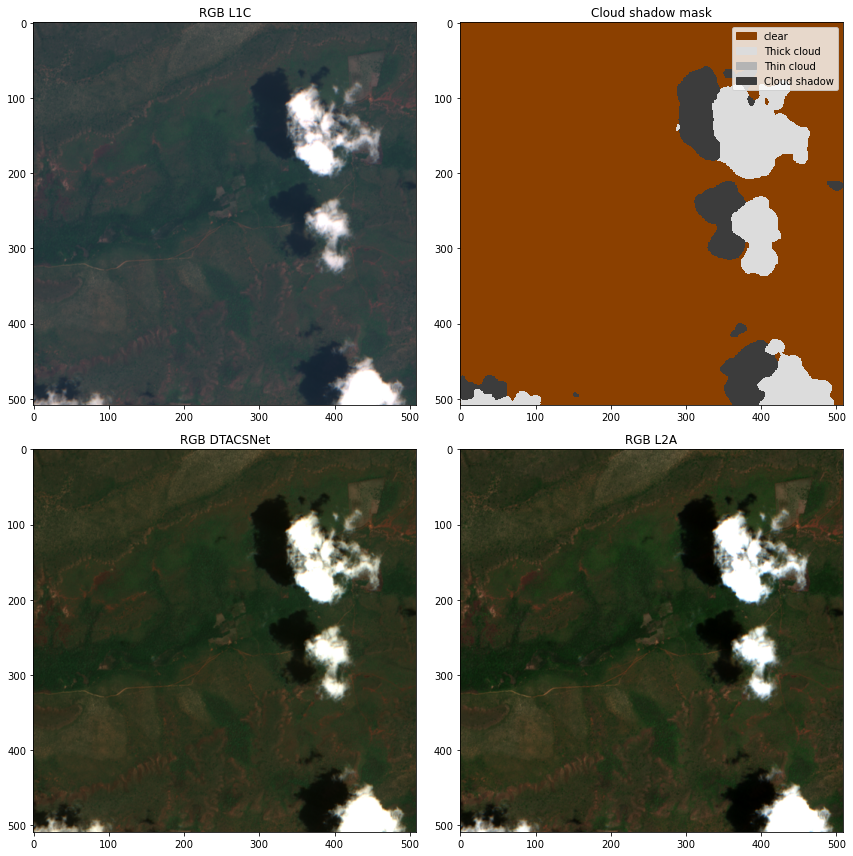

In [7]:
import matplotlib.pyplot as plt
from dtacs import plot
import rasterio.plot as rstplt

# Load L2A to show
with rasterio.open(os.path.join(folder_examples,"S2L2A.tif")) as rst:
    indexes_read = [rst.descriptions.index(b) + 1 for b in phisat2_bands]
    data_sen2cor = rst.read(indexes_read)

fig, ax = plt.subplots(2,2,figsize=(12,12),tight_layout=True)

rstplt.show(data[2::-1,...]/4_000,ax=ax[0,0])
ax[0,0].set_title("RGB L1C")
rstplt.show(ac_output[2::-1,...]/4_000,ax=ax[1,0])
ax[1,0].set_title("RGB DTACSNet")
rstplt.show(data_sen2cor[2::-1,...]/4_000,ax=ax[1,1])
ax[1,1].set_title("RGB L2A")
plot.plot_cloudSEN12mask(cd_output,ax=ax[0,1])
ax[0,1].set_title("Cloud shadow mask")